In [34]:
import pandas as pd
import numpy as np
import math
from graphviz import Digraph
from itertools import product
from uuid import uuid4
import warnings

warnings.filterwarnings('ignore')

In [35]:
from sklearn import tree
from sklearn.metrics import accuracy_score

In [36]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Callable, Any

In [37]:
@dataclass
class Node:
    label: str
    attr: str
    attr_value: Any
    branches: list[Node]
    _id: uuid.UUID = field(default_factory=uuid4)

In [38]:
class ID3:
    def __init__(self, split_func: Callable[[pd.DataFrame, pd.DataFrame], float], vote_func: Callable[pd.DataFrame, str]):
        self.split_func = split_func
        self.vote_func = vote_func
        self.root: Node = None
        self.g = Digraph('Tree')
        self.label_map = None
        
    def generate_label_idx(self, labels):
        self.label_map = {}
        for i, label in enumerate(labels):
            self.label_map[label] = i+1
            
    def predict(self, X: pd.DataFrame):
        def _predict_tuple(x: pd.Series):
            node = list(filter(lambda n: n.attr_value == x[n.attr], self.root.branches))[0]
            if node.label is not None:
                return node.label
            while node.label is None:
                node = list(filter(lambda n: n.attr_value == x[n.attr], node.branches))[0]
                if node.label is not None:
                    return node.label
            
        return X.apply(_predict_tuple, axis=1)
        
    def fit(self, X: pd.DataFrame, y_col: str, root: Node = None) -> Node:
        cols = X.columns.to_list()
        cols.remove(y_col)
        y = X.loc[:, y_col]
        labels = set(y.to_list())
        
        if self.label_map is None:
            self.generate_label_idx(labels)
        
        if self.root == None:
            root = Node(label=None, attr="", attr_value=None, branches=[])
            self.root = root
        
        if len(labels) < 2:
            root.label = labels.pop()
            return root
        
        if len(cols) < 1:
            root.label = self.vote_func(y)#.idxmax()
            #y.value_counts().idxmax() # vote
            return root
        
        score_attr = { c: self.split_func(X.loc[:, c], y) for c in cols } # score per each attr
        # here i changed max per min because in our info gain we don't consider the entropy before the partition
        # and we want to maximize this result (entropy before - entropy of attribute A), to maximize it we just
        # need to minimize entropy of attribute A.
        best_attr = min(score_attr, key=score_attr.get)
                                                        
        attr_values = set(X.loc[:, best_attr].values)
        
        for v in attr_values:
            child = Node(attr=best_attr, attr_value=v, branches=[], label=None)
            root.branches.append(child)
            
            subset = X[X[best_attr] == v]
            subset = subset.loc[:, subset.columns != best_attr] # removing the best attr from the data
            self.fit(subset, y_col, child)
        
    def __str__(self):
        return self._pprint(self.root)
        
    def _pprint(self, node, level=0):
        if node is None:
            return ""
        
        string = "-"*2*level + f" attr: {node.attr}, attr_val: {node.attr_value}, label: {node.label}\n"
        for n in node.branches:
            string = string + self._pprint(n, level=level+1)
        
        return string
    
    def _draw_tree(self, root, level=0):
        if root is None:
            return
        
        if root is self.root:
            with self.g.subgraph(name=f'sub_{level}') as c:
                c.attr('node',shape='circle', fillcolor='white', color='black')
                c.node(f"{root._id}", label=f"root")
        
        for node in root.branches:
            with self.g.subgraph(name=f'sub_{level}') as c:
                if node.label is not None:
                    c.attr('node', rank='same', style='filled', shape='oval', fillcolor=f'/accent8/{self.label_map[node.label]}')
                else:
                    c.attr('node', rank='same', shape='oval', fillcolor='white', color='black')
                    
                c.node(f"{node._id}", label=f"{node.attr}\n{node.attr_value}")
                c.edge(f"{root._id}", f"{node._id}")
                
        for node in root.branches:
            self._draw_tree(node, level=level+1)
            
    def draw(self):
        self._draw_tree(self.root)
        display(self.g)

## Default Split and Vote functions

Entropy, where Pi is the frequentist probability of an element has label i in the data
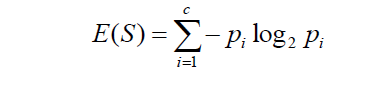

In [39]:
def _entropy(X: pd.DataFrame, y: pd.DataFrame) -> float:
    pi = y[X.index].value_counts(normalize=True) # relative frequency of labels in an attribute value a\inA
    return -sum([p*math.log2(p) for p in pi])

def info_gain(X: pd.DataFrame, y: pd.DataFrame) -> float: # it's not really the info gain but the entropy of attr A
    counts = X.value_counts(normalize=True).to_dict()
    return (sum([v*_entropy(X[X == k], y) for k,v in counts.items()])) # gain of an attribute

In [40]:
def majority(y: pd.DataFrame):
    return y.value_counts().idxmax()

## DP Split and Vote function
Blum et al. 2005

In [41]:
from scipy.stats import laplace

def dp_info_gain(X: pd.DataFrame, y: pd.DataFrame, eps: float) -> float: # it's not really the info gain but the entropy of attr A
    noise = laplace.rvs(loc=0, scale=1/eps, size=X.unique().shape[0])
    counts = X.value_counts(normalize=True).to_dict()
    counts = { k: v + noise[i] for i,(k,v) in enumerate(counts.items())}
    return (sum([v*_entropy(X[X == k], y) for k,v in counts.items()])) # gain of an attribute

def dp_majority(y:pd.DataFrame, eps: float):
    noise = laplace.rvs(loc=0, scale=1/eps, size=y.unique().shape[0])
    return (y.value_counts() + noise).idxmax()

# Lipschitz condition to verify if individual fairness is achieved

In [42]:
def bound_d(dataset: pd.DataFrame) -> float:
    def distance_l_infty_num(dataset: pd.DataFrame, ind_x: int, ind_y: int) -> float:
        num_attr = list(dataset.iloc[:, :-1]._get_numeric_data().columns)
        diff = list(dataset[num_attr].loc[ind_x].values - dataset[num_attr].loc[ind_y].values)
        return np.linalg.norm(diff, np.inf)
    
    def distance_l_infty_cat(dataset: pd.DataFrame, ind_x: int, ind_y: int, cat_attr: list) -> float:
        def cat_distance(dataset: pd.DataFrame, ind_x: int, ind_y: int, cat_attr: list):
            return list(map(int, (dataset[cat_attr].loc[ind_x] != dataset[cat_attr].loc[ind_y])))
        
        num_attr = list(dataset.iloc[:, :-1]._get_numeric_data().columns)
        diff = list(dataset[num_attr].loc[ind_x].values - dataset[num_attr].loc[ind_y].values)
        [diff.append(d) for d in cat_distance(dataset, ind_x, ind_y, cat_attr)]
        
        return np.linalg.norm(diff, np.inf)
    
    copy = dataset.copy()
    copy = copy.drop_duplicates()
    indexes = list(copy.index) #I did it because we don't want to count equal tuples, because its distance will be 0
                               #and to make sure that we are count the same tuples that we passed as parameter and not
                               #another tuple, it could happen if in 'for' we only consider i, j as increasing order.  
    min_bound = np.infty
    only_numeric_data = copy.drop(copy._get_numeric_data().columns, axis=1).iloc[:,:-1].empty
    cat_attr = list((copy.drop(copy._get_numeric_data().columns, axis=1).iloc[:,:-1]).columns)
    
    for i in range(len(indexes)-1):
        for j in range(i+1, len(indexes)):
            if(only_numeric_data):
                dist_i_j = distance_l_infty_num(copy, indexes[i], indexes[j])
            elif(not only_numeric_data):
                dist_i_j = distance_l_infty_cat(copy, indexes[i], indexes[j], cat_attr)
            if(dist_i_j < min_bound):
                min_bound = min(min_bound, dist_i_j)
                tuples = (indexes[i], indexes[j])
            
    return min_bound, tuples

In [43]:
#This function will be used in dissimilarity calculation and to achieve fairness where we need to change the leaves
#values, whether necessary.

def find_leaf(dataset: pd.DataFrame, root, ind: pd.Series, columns: list, label: str, to_search: dict = {}):
    if(root.label != None):
        query = dataset.copy()
        for i in range(len(to_search)):
            query = query[query[list(to_search.keys())[i]] == list(to_search.values())[i]]
        
        count_dict, unique_labels = dict(query[label].value_counts()), dataset[label].unique()
        if(len(count_dict) < len(unique_labels)):
            p = {}
            for i in unique_labels:
                if i in count_dict:
                    p[i] = count_dict[i]
                else:
                    p[i] = 0 
            return p
            
        return count_dict

    for branch in root.branches:
        if(ind[branch.attr] == branch.attr_value):
            to_search[branch.attr] = branch.attr_value
            columns.remove(branch.attr)
            return find_leaf(dataset, branch, ind, columns, label, to_search)

In [44]:
def dissimilarity(dataset: pd.DataFrame, root, label: str, ind_x: int, ind_y: int) -> float:            
    pdf_x = find_leaf(dataset, root, dataset.loc[ind_x][:-1], list(dataset.loc[ind_x][:-1].keys()), label)
    pdf_y = find_leaf(dataset, root, dataset.loc[ind_y][:-1], list(dataset.loc[ind_y][:-1].keys()), label)
    #print(pdf_x, pdf_y)
    
    return max([np.log(max(1 if pdf_x[a] == 0 and pdf_y[a] == 0 else np.infty if pdf_y[a] == 0 else pdf_x[a]/pdf_y[a], \
                           1 if pdf_y[a] == 0 and pdf_x[a] == 0 else np.infty if pdf_x[a] == 0 else pdf_y[a]/pdf_x[a])) 
                for a in dataset[label].unique()])

In [18]:
dissimilarity(X, tree.root, 'target', 7, 29)

0.6190392084062235

In [45]:
def verify_lipschitz(X: pd.DataFrame, tree, label: str) -> list:
    unique_rows = X.drop_duplicates()
    lower_bound = bound_d(unique_rows)[0]
    dissimilarities = []
    indexes_X = list(X.index)
    
    for x in range(len(X)-1):
        for y in range(x+1, len(X)): 
            d_xy = dissimilarity(X, tree.root, label, indexes_X[x], indexes_X[y])
            if d_xy > lower_bound:
                dissimilarities.append([d_xy, (indexes_X[x], indexes_X[y])])
                
    return dissimilarities

In [32]:
d = find_leaf(X, tree.root, X.loc[7], list(X.loc[0][:-1].keys()), 'target')
d

{0: 0, 1: 0, 2: 0}

In [46]:
def achieving_fairness(X: pd.DataFrame, tree, lower_bound: float, label: str):
    def diss(X: pd.DataFrame, pdf_x: dict, pdf_y: dict, label: str):
        #In Dwork's paper, we want the metric of dissimilarity is the max of log_list
        log_list = [np.log(max(1 if pdf_x[a] == 0 and pdf_y[a] == 0 else np.infty if pdf_y[a] == 0 else pdf_x[a]/pdf_y[a], \
                               1 if pdf_y[a] == 0 and pdf_x[a] == 0 else np.infty if pdf_x[a] == 0 else pdf_y[a]/pdf_x[a])) \
                    for a in X[label].unique()]

        index_label_max = log_list.index(max(log_list))

        return max(log_list), index_label_max
        
    def redistribution(X: pd.DataFrame, root, lower_bound: float, label: str, ind_x: pd.Series, ind_y: pd.Series):
        pdf_x = find_leaf(X, root, ind_x, list(X.loc[ind_x][:-1].keys(), label))
        pdf_y = find_leaf(X, root, ind_y, list(X.loc[ind_y][:-1].keys(), label))
        #while diss(X, pdf_x, pdf_y, label) < lower_bound:
            
            
        
    not_satisfying = np.array(verify_lipschitz(X, tree, label)).T[1]
    for i,j in not_satisfying:
        redistribution(X, tree.root, lower_bound, label, X.loc[i], X.loc[j])

In [69]:
pdf_x = {0: 0, 1: 3, 2: 0}
pdf_y = {0: 0, 1: 6, 2: 0}

label = 'target'

#In Dwork's paper, we want the metric of dissimilarity is the max of log_list
log_list = [np.log(max(1 if pdf_x[a] == 0 and pdf_y[a] == 0 else np.infty if pdf_y[a] == 0 else pdf_x[a]/pdf_y[a], \
1 if pdf_y[a] == 0 and pdf_x[a] == 0 else np.infty if pdf_x[a] == 0 else pdf_y[a]/pdf_x[a])) \
for a in X[label].unique()] 

index_label_max = log_list.index(max(log_list))

max(log_list), index_label_max

(0.6931471805599453, 1)

### MODIFICAR TODOS OS REGISTROS SEGUINTES PARA QUE ATENDAM A CONDIÇÃO DE LIPSCHITZ

In [53]:
bound_d(X)

(0.09999999999999964, (7, 39))

In [88]:
# IRIS DATASET 

unique_rows = X.drop_duplicates()
bound_d(unique_rows)
shuffled_iris = X.reindex(np.random.permutation(X.index))
#shuffled_iris = shuffled_iris.set_index(np.arange(len(shuffled_iris)))
verification_X = verify_lipschitz(shuffled_iris, tree, 'target')
#verification_X

In [215]:
#ADULT DATASET

shuffled = adult[:1000].reindex(np.random.permutation(adult[:1000].index))[:100]
#shuffled = shuffled.set_index(np.arange(len(shuffled)))
verification = verify_lipschitz(shuffled, tree, 'income')
np.array(verification).T[1]

array([(0, 1), (0, 2), (0, 3), ..., (96, 99), (97, 98), (97, 99)],
      dtype=object)

## Testing

In [47]:
from sklearn.datasets import load_iris
data = load_iris()

In [48]:
X = pd.DataFrame(data.data, columns=data.feature_names)

In [49]:
X.columns = ["sep_len", "sep_wid", "petal_len", "petal_wid"]
X['target'] = data['target']

Accuracy: 1.0


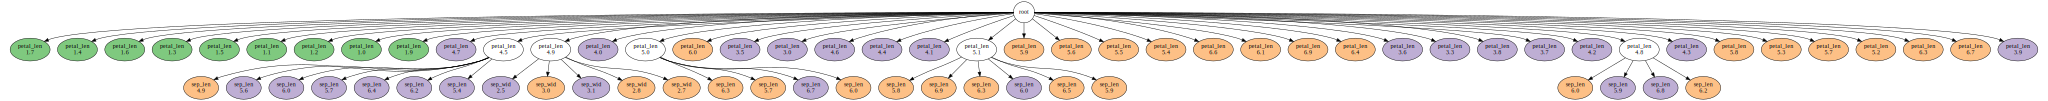

In [50]:
tree = ID3(info_gain, majority)
tree.fit(X, 'target')
y_pred = tree.predict(X)
acc = accuracy_score(X['target'], y_pred)
print(f'Accuracy: {acc}')
tree.draw()

In [87]:
#verify_lipschitz(X, tree, 'target')

In [17]:
outlook = 'overcast,overcast,overcast,overcast,rainy,rainy,rainy,rainy,rainy,sunny,sunny,sunny,sunny,sunny'.split(',')
temp = 'hot,cool,mild,hot,mild,cool,cool,mild,mild,hot,hot,mild,cool,mild'.split(',')
humidity = 'high,normal,high,normal,high,normal,normal,normal,high,high,high,high,normal,normal'.split(',')
windy = 'FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE'.split(',')
play = 'yes,yes,yes,yes,yes,yes,no,yes,no,no,no,no,yes,yes'.split(',')
dataset ={'outlook':outlook,'temp':temp,'humidity':humidity,'windy':windy,'play':play}
df = pd.DataFrame(dataset,columns=['outlook','temp','humidity','windy','play'])

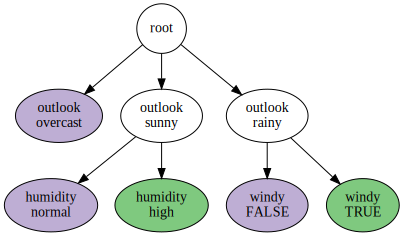

In [19]:
tree = ID3(info_gain, majority)
tree.fit(df, 'play')
#print(tree)
tree.draw()

# Bounding distance to dissimilarity on adult dataset

In [44]:
%run bounding_distance_adult.ipynb

In [152]:
adult = updating_values(reading_adult_csv())

In [155]:
tree = ID3(info_gain, majority)
tree.fit(adult[:1000], 'income')
y_pred = tree.predict(adult[:1000])
acc = accuracy_score(adult['income'][:1000], y_pred)
print(f'Accuracy: {acc}')
tree.draw()

Accuracy: 0.999
